Consider the winequality-red.csv dataset (available at the webpage) where the goal is to estimate
the quality (sensory appreciation) of a wine based on physicochemical inputs.
Using a 80-20 training-test split with a fixed seed (random_state=0), you are asked to learn MLP
regressors to answer the following questions.
Given their stochastic behavior, average the performance of each MLP from 10 runs
(for reproducibility consider seeding the MLPs with random_state ∈ {1. .10}).

In [7]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

simplefilter("ignore", category=ConvergenceWarning)

In [8]:
import pandas as pd

df = pd.read_csv('data/winequality-red.csv', sep=';')
X, y = df.drop('quality', axis=1), df['quality']

1) [3.5v] Learn a MLP regressor with 2 hidden layers of size 10, rectifier linear unit activation
on all nodes, and early stopping with 20% of training data set aside for validation. All
remaining parameters (e.g., loss, batch size, regularization term, solver) should be set as
default. Plot the distribution of the residues (in absolute value) using a histogram.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

# Not converging with the 200 default iterations (had to make it bigger)
regressors = [MLPRegressor(hidden_layer_sizes=(10, 10), activation='relu', early_stopping=True,
                           validation_fraction=0.2, random_state=k, max_iter=500) for k in range(1, 11)]

for r in regressors:
    r.fit(X_train, y_train)

y_test_pred = [r.predict(X_test) for r in regressors]
residues = [np.abs(np.array(x)-np.array(y_test)) for x in y_test_pred]
residues = [y for x in residues for y in x]

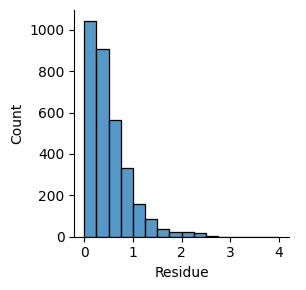

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_df = pd.DataFrame(residues, columns=["Residue"])
plot=sns.FacetGrid(plot_df)
plot.map(sns.histplot, "Residue", binwidth=0.25).add_legend()
plt.show()

2) [1.5v] Since we are in the presence of a integer regression task, a recommended trick is to
round and bound estimates. Assess the impact of these operations on the MAE of the MLP
learnt in previous question.

In [11]:
from sklearn.metrics import mean_absolute_error

def round_and_bound(x):
    if x <= 1:
        return 0
    if x >= 10:
        return 10
    
    return np.round(x)

y_test_pred_round = [[round_and_bound(y) for y in z] for z in y_test_pred]

original_maes = [mean_absolute_error(y_test, pred) for pred in y_test_pred]
new_maes = [mean_absolute_error(y_test, pred) for pred in y_test_pred_round]

original_mae = sum(original_maes)/len(original_maes)
new_mae = sum(new_maes)/len(new_maes)

print("Original MAE: ", original_mae)
print("Round and Bound MAE: ", new_mae)

Original MAE:  0.5029284566642892
Round and Bound MAE:  0.42718749999999994


Rounding and bounding seems to decrease the MAE since all of the expected values are integer, meaning that small error created by the prediction will be removed, resulting in a smaller average error.

3) [1.5v] Similarly assess the impact on RMSE from replacing early stopping by a well-defined
number of iterations in {20,50,100,200} (where one iteration corresponds to a batch).

In [12]:
from sklearn.metrics import mean_squared_error

new_regressors = [[MLPRegressor(hidden_layer_sizes=(10, 10), activation='relu', random_state=k, max_iter=n) 
                   for k in range(1, 11)] for n in [20, 50, 100, 200]]

for r in new_regressors:
    for k in r:
        k.fit(X_train, y_train)

original_rmses = [np.sqrt(mean_squared_error(y_test, pred)) for pred in y_test_pred]
original_rmse = sum(original_rmses)/len(original_rmses)

new_predictions = [[x.predict(X_test) for x in iter] for iter in new_regressors]
new_predictions_rmses = [[np.sqrt(mean_squared_error(y_test, pred)) for pred in iter] for iter in new_predictions]
new_predictions_rmse = [sum(iter)/len(iter) for iter in new_predictions_rmses]

print("With early stopping: ", original_rmse)
print("With 20, 50, 100, 200 iterations: ", new_predictions_rmse)

With early stopping:  0.6637609053030582
With 20, 50, 100, 200 iterations:  [1.403978950992544, 0.7996073631460566, 0.6940361469112144, 0.6554543932216477]


4) [1.5v] Critically comment the results obtained in previous question, hypothesizing at least
one reason why early stopping favors and/or worsens performance.

The early stopping mechanism avoids underfitting and overfitting, since early stopping uses a portion of the training data (validation data) and stops when the error starts increasing. This avoids underfitting since it avoids being stuck on local minima (since this implementation uses the early stopping together with stochastic gradient descent), that's the reason why the early stopping RMSE is lower than the lower end of fixed iteration numbers (20, 50, 100). It also avoids overfitting since it trains using a certain set while validating with another. Although, since the validation and the testing data sets are different, there isn't a guarantee that early stopping will grant the best score for the testing data (it's possible that the validation data doesn't represent the population, meaning that it will be impossible to generalize). This means that it is possible that the RMSE of the early stopping model is higher than the RMSE of a model with a specific number of iterations.